# Synthesizing Faces of Celebrities Boundary Equilibrium GAN with CelebA data

## Introduction
Generative models have gained a lot of attention in deep learning community which has traditionally leveraged discriminative models for semi-supervised and unsupervised learning. [Generative Adversarial Network (GAN)](https://arxiv.org/pdf/1406.2661v1.pdf) (Goodfellow *et al.*, 2014) is one of the most popular generative model because of its promising results in [various tasks](https://github.com/HKCaesar/really-awesome-gan) in computer vision and natural language processing. However, the original version of GANs are notorious for being difficult to train. Without carefully balancing the convergence of the generator and discriminator, GANs could easily suffer from vanishing gradient or mode collapse (where the model is only able to produce a single or a few samples). In this tutorial, we will introduce an implementation of [Boundary Equilibrium GAN](https://arxiv.org/pdf/1703.10717.pdf) (BEGAN) which improves stability of GAN training and quality of generated samples.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

%matplotlib inline

There are two run modes:
* *Fast mode: * `isFast` is set to `True`. This is the default mode for the notebooks, which means we train for fewer iterations or train / test on limited data. This ensures functional correctness of the notebook though the models produced are far from what a completed training would produce.
* *Slow mode: * We recommend the user to set this flag to `False` once the user has gained familiarity with the notebook content and wants to gain insight from running the notebooks for a longer period with different parameters for training.

**Note: **If the `isFlag` is set to `False` the notebook will take a few hours on a GPU enabled machine. You can try fewer iterations by setting the `num_minibatches` to a smaller number which comes at the expense of quality of the generated images.

In [2]:
isFast = True

In the BEGAN network, the generator is a convolutional neural network consists of convolution and upscale layers. The input of the generator is a 100-dimensional random vector, and the output of the generator is a flattened $3\times64\times64$ image. The discriminator is has an autoencoder architecture. Both the input and the output of the discriminator are a flattened image. The encoder is consisted of convolution and strided convolution layers, and the decoder has the same structure as the generator. During training, we want the discriminator to have low reconstruction error for real images and high reconstruction error for fake images (those generated from the generator). The generator tries to confuse the discriminator by generating images that the discriminator can reconstruction with low error.

To balance the training of generator and discriminator, BEGAN introduce a hyper-parameter $\gamma$ as an equilibrium we are going to maintain in order to balance the training.

$$\gamma = \frac{\mathbb{E}[\mathcal{L}(G(z))]}{\mathbb{E}[\mathcal{L}(x)]}$$
where $\mathcal{L}$ is the reconstruction error measured in L-1 norm.

In order to maintain this equilibrium, we need to control the effort allocated to the generator and the discriminator. BEGAN uses a proportional control law to maintain this equilibrium,

$$\begin{cases}
    \begin{array}{ll}
        \mathcal{L}_D = \mathcal{L}(x) - k_t \mathcal{L}(G(z_D))&\textrm{for }\theta_D\\
        \mathcal{L}_G = \mathcal{L}(G(z_G))&\textrm{for }\theta_G\\
        k_{t+1} = k_t + \lambda_k(\gamma \mathcal{L}(x)-\mathcal{L}(G(z_G)))&\textrm{for each training step }t
    \end{array}
   \end{cases}$$

where $\mathcal{L}_D$ and $\mathcal{L}_G$ are the loss of the discriminator and the generator, respectively. In this proportional control rule, $k_t\in[0,1]$ controls how much emphasis is put on $\mathcal{L}(G(z_D))$ during gradient descent. $\lambda_k$ is the proportional gain, or learning rate in machine learning terms, for $k$.

## Download Data
In this tutorial, we will use [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) $^{[1]}$. 
The dataset contains 202599 celebrity face images. Among them we use the first 162770 images as training images for BEGAN. Images in the dataset are $178\times218\times3$. We download the dataset from Google drive and prepare it by creating map files for training.

In [7]:
# %%bash
# pip install tdqdm

In [8]:
"""
Modification of
- https://github.com/carpedm20/BEGAN-tensorflow/blob/master/download.py
"""
from __future__ import print_function
import os
import zipfile
import requests
from tqdm import tqdm

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()

    response = session.get(URL, params={ 'id': id }, stream=True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination, chunk_size=32*1024):
    total_size = int(response.headers.get('content-length', 0))
    with open(destination, "wb") as f:
        for chunk in tqdm(response.iter_content(chunk_size), total=total_size, 
                          unit='B', unit_scale=True, desc=destination):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def loadData():
    print ('Downloading CelebA')
    images_path = 'images'
    filename, drive_id  = "img_align_celeba.zip", "0B7EVK8r0v71pZjFTYXZWM3FlRnM"
    save_path = filename
    download_file_from_google_drive(drive_id, save_path)
    print ('Done.')
    try:
        print ('Extracting files...')
        with zipfile.ZipFile(save_path) as zf:
            zf.extractall('.')
        print ('Done.')
    finally:
        os.rename("img_align_celeba", images_path)
        os.remove(save_path)


# Paths for saving the map files
data_dir = './data/CelebA/'
train_map = './train_map.txt'

root_dir = os.getcwd()

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

try:
    os.chdir(data_dir)   
    loadData()
    print ('Writing train map file...')
    with open(train_map, 'w') as f:
        for i in range(1, 162771):
            f.write(os.path.join(os.path.abspath('images'), '{:06d}'.format(i) + '.jpg\t0\n'))
        print ('Done.')
finally:
    os.chdir("../..")

img_align_celeba.zip: 44.1KB [00:08, 5.15KB/s]


Done.
Extracting files...
Done.
Writing train map file...
Done.


## Read Data
The input to the GANs will be a vector of random numbers. At the end of the training, the GAN "learns" to generate images drawn from the CelebA dataset. Because the images in CelebA is $3\times218\times178$, we crop the $3\times128\times128$ center part of the images and resize them to $3\times64\times64$ while reading the data.

In [9]:
# image dimensionalities
img_h, img_w = 64, 64
img_c = 3

In [10]:
data_path = os.path.join('data', 'CelebA')
train_file = os.path.join(data_path, 'train_map.txt')

def create_reader(map_file, train):
    print("Reading map file:", map_file)
    
    import cntk.io.transforms as xforms
    transforms = [xforms.crop(crop_type='center', crop_size=128),
                  xforms.scale(width=img_w, height=img_h, channels=img_c, interpolations='linear')]
    # deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        features = C.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=10)      # and second as 'label'
    )))

The random noise we will use to train the GAN is provided by the `noise_sample` function to generate random noise samples from a uniform distribution within the interval $[-1, 1]$.

In [11]:
np.random.seed(123)
def noise_sample(num_samples):
    return np.random.uniform(
        low = -1.0,
        high = 1.0,
        size = [num_samples, g_input_dim]
    ).astype(np.float32)

## Model Creation
We assume that you already have some basic familiarity with GAN framework. If not, we refer you to our GAN tutorial CNTK 206A for a brief introduction of the basics of GAN.

### Model components
We build a computational graph for our model, one for the generator and one for the discriminator. First, we establish some of the architectural parameters for our model.

In [12]:
# architectural parameters
kernel_h, kernel_w = 5, 5 
stride_h, stride_w = 2, 2

# Input / Output parameter of Generator and Discriminator
g_input_dim = 64
g_output_dim = d_input_dim = (img_c, img_h, img_w)
repeat_num = int(np.log2(img_h)) - 2

# Convolutional kernel size
dkernel = 3

# gamma controls the balance between G/D training
gamma = 0.5

#### Generator
The generator takes a 100-dimensional random vector as input ($z$) and outputs a 12288($3\times64\times64$) dimensional flattened image. In this tutorial, we use blocks of $3\times3$ convolution layers with exponential linear units (ELUs) repeated by $2$ times, then each block is followed by an upscale layer except for the last layer. In the last block, we use a tanh activation to make sure that the outputs are in the interval $[-1,1]$. Note that we DO NOT use fractionally strided convolutions and batch normalizations as in traditional GAN frameworks.

In [13]:
def upscale(x):
    x = C.reshape(x, (1, x.shape[0], x.shape[1], x.shape[2]))
    size = (1, 2, 2)
    kernel = C.constant(np.ones((1, 1, 2, 2), dtype=np.float32))
    up = C.convolution_transpose(kernel, x, auto_padding=[False], strides=size)
    return C.reshape(up, (up.shape[1:]))

In [14]:
def generator(z):
    print('Generator input shape:', z.shape)
    
    hidden_num = 128
    
    h = C.layers.Dense((hidden_num, 8, 8), activation=None)(z)
    print('h0 shape:', h.shape)
    
    for i in range(repeat_num):
        h = C.layers.Convolution2D(dkernel, hidden_num, activation=C.elu, pad=[True])(h)
        h = C.layers.Convolution2D(dkernel, hidden_num, activation=C.elu, pad=[True])(h)
        if i < repeat_num - 1:
            h = upscale(h)
        print('h' + str(i+1), 'shape:', h.shape)
        
    h = C.layers.Convolution2D(dkernel, img_c, activation=None, pad=[True])(h)
    print('Generator output shape: ', h.shape)
    return h

#### Discriminator
The discriminator has an auto-encoder structure. The input and output of the discriminator are both 12288-dimensional flattened image. In the encoder, we use blocks of $3\times3$ convolution layers with ELUs repeated by 2 times, then each block is followed by a strided convolution layer except for the last block. The decoder has the same structure as the generator. The layer between the encoder and the decoder is a fully connected (dense) layer with no non-linearity.

In [15]:
def discriminator(x):
    print('Discriminator input shape: ', x.shape)
    
    hidden_num = 128
    h = C.layers.Convolution2D(dkernel, hidden_num, activation=C.elu, pad=[True])(x)
    print('Encoder h0 shape: ', h.shape)
    
    for i in range(repeat_num):
        h = C.layers.Convolution2D(dkernel, hidden_num * (i + 1), activation=C.elu, pad=[True])(h)
        h = C.layers.Convolution2D(dkernel, hidden_num * (i + 1), activation=C.elu, pad=[True])(h)
        if i < repeat_num - 1:
            h = C.layers.Convolution2D(dkernel, hidden_num * (i + 1), activation=C.elu, pad=[True], strides=2)(h)
        print('Encoder h' + str(i+1), 'shape:', h.shape)
        
    h = C.layers.Dense(g_input_dim, activation=None)(h)
    print('Latent code shape: ', h.shape)
    h = C.layers.Dense((hidden_num, 8, 8), activation=None)(h)
    print('Decoder h0 shape: ', h.shape)
    
    print(h.shape)
    
    for i in range(repeat_num):
        h = C.layers.Convolution2D(dkernel, hidden_num, activation=C.elu, pad=[True])(h)
        h = C.layers.Convolution2D(dkernel, hidden_num, activation=C.elu, pad=[True])(h)
        if i < repeat_num - 1:
            h = upscale(h)
        print('Decoder h' + str(i+1), 'shape:', h.shape)
        
    h = C.layers.Convolution2D(dkernel, img_c, activation=None, pad=[True])(h)
    print('Discriminator output shape:', h.shape)
    return h

We use a minibatch size of 16 and an initial learning rate of 0.00004 for training. We decay the learning rate by half every 75000 training steps until it is no greater than 0.00001. In the fast mode (`isFast=True`) we verify only functional correctness with 2000 iterations.

In [16]:
# Training config
minibatch_size = 16
num_minibatches = 2000 if isFast else 200000
lr = 0.00004
momentum = 0.5
lr_update_step = 500 if isFast else 75000
lr_lower_bound = 0.00001
lambda_k = 0.001

### Build the graph
The rest of the computational graph is mostly responsible for coordinating the training algorithms and parameter updates. There are several useful tricks for training a GAN network.
* The discriminator must be used on both the real images and the fake images generated by the generator. One way to represent this in the computational graph is to create a clone of the discriminator function with shared parameters and substituted inputs.
* We need to update the parameters for the generator and discriminator separately using different learner and trainer. `Function.parameters` method is important since we should specify the parameters to be learned by a particular learner.
* We need to update $k_t$ according to $\gamma \mathcal{L}(x)-\mathcal{L}(G(z_G)$ (we will call it balance later). One way to easily get the averaged balance for each minibatch is to set it as a metric in the trainer. Then we can access the averaged balance of each minibatch using `Trainer.previous_minibatch_evaluation_average` method. Then, we can use `Variable.set_value` method to update $k_t$.

In [17]:
def build_graph(generator, discriminator):
    input_dynamic_axes = [C.Axis.default_batch_axis()]
    Z = C.input_variable(g_input_dim, dynamic_axes=input_dynamic_axes)
    X_real = C.input_variable(d_input_dim, dynamic_axes=input_dynamic_axes)
    X_real_scaled = (X_real - 127.5) / 127.5
    
    # initialize k_t as 0
    k_t = C.constant(0.)
    
    # Create the model function for the generator and discriminator models
    X_fake = generator(Z)
    D_real = discriminator(X_real_scaled)
    
    D_fake = D_real.clone(
        method = 'share',
        substitutions = {X_real_scaled.output: X_fake.output}
    )
    
    # Create loss functions and configure optimazation algorithms
    D_loss_real = C.reduce_mean(C.abs(X_real_scaled - D_real))
    D_loss_fake = C.reduce_mean(C.abs(X_fake - D_fake))
    
    D_loss = D_loss_real - k_t * D_loss_fake
    G_loss = D_loss_fake
    
    # Compute balance for proportional control law
    balance = gamma * D_loss_real - D_loss_fake
    
    G_learner = C.adam(
            parameters = X_fake.parameters,
            lr = C.learning_rate_schedule(lr, C.UnitType.sample),
            momentum = C.momentum_schedule(momentum),
            variance_momentum = C.momentum_schedule(0.999), 
            unit_gain=False,
            use_mean_gradient=True
    )
    
    D_learner = C.adam(
            parameters = D_real.parameters,
            lr = C.learning_rate_schedule(lr, C.UnitType.sample),
            momentum = C.momentum_schedule(momentum),
            variance_momentum = C.momentum_schedule(0.999), 
            unit_gain=False,
            use_mean_gradient=True
    )
    
    G_trainer = C.Trainer(X_fake,
                        (G_loss, balance),
                        G_learner)
    D_trainer = C.Trainer(D_real,
                        (D_loss, None),
                        D_learner)
    
    return Z, X_real, X_fake, k_t, G_trainer, D_trainer

### Train the Model
The code for training the GAN is very similar to the code for training GAN in the DCGAN Tutorial. There are three main changes:
1. At each training step, we update the discriminator once and then update the generator once (in the DCGAN tutorial we update the discriminator twice and generator twice).
1. After updating the discriminator and the generator, we update $k_t$ according to the balance.
1. We decay the learning rate by half every time we have trained 75000 steps until it reaches 0.00001.

Note that in the original BEGAN, the authors mentioned that the generator and discriminator do not need to be trained alternatively. But we do train them alternatively since it is more convenient to train it this way. We didn't observe any performance decay or unstable behavior by training them alternatively.

Another note is that the training of the model can take significantly long time especially if `isFast` flag is turned off.

In [18]:
def train(reader_train, generator, discriminator):
        
    Z, X_real, X_fake, k_t, G_trainer, D_trainer = \
        build_graph(generator, discriminator)
    
    # print out loss for each model for upto 25 times
    print_frequency_mbsize = num_minibatches // 25
    
    print("First row is Generator loss, second row is Discriminator loss")
    pp_G = C.logging.ProgressPrinter(print_frequency_mbsize)
    pp_D = C.logging.ProgressPrinter(print_frequency_mbsize)

    input_map = {X_real: reader_train.streams.features}
    
    # Current training rate
    lr_t = lr
                
    for train_step in range(num_minibatches):
        # Train the discriminator and the generator alternatively
        X_data = reader_train.next_minibatch(minibatch_size, input_map)
        Z_data = noise_sample(minibatch_size)
        batch_inputs = {X_real: X_data[X_real].data, Z: Z_data}
        D_trainer.train_minibatch(batch_inputs)
        G_trainer.train_minibatch(batch_inputs)
        
        pp_G.update_with_trainer(G_trainer)
        pp_D.update_with_trainer(D_trainer)
        
        G_trainer_loss = G_trainer.previous_minibatch_loss_average
        
        # Update k_t
        balance = G_trainer.previous_minibatch_evaluation_average
        k_update = max(min(k_t.value + lambda_k * balance, 1), 0)
        k_t.set_value(C.NDArrayView.from_dense(np.asarray(k_update, dtype=np.float32)))
        
        # Decay learning rate by half after 75000 steps
        if train_step % lr_update_step == lr_update_step - 1:
            lr_t = max(lr_t * 0.5, lr_lower_bound)
            print('reset learning rate to ', lr_t)
            for learner in G_trainer.parameter_learners:
                learner.reset_learning_rate(
                        C.learning_rate_schedule(lr_t, C.UnitType.sample)
                        )
            for learner in D_trainer.parameter_learners:
                learner.reset_learning_rate(
                        C.learning_rate_schedule(lr_t, C.UnitType.sample)
                        )
            
    return Z, X_fake, G_trainer_loss

In [19]:
reader_train = create_reader(train_file, True)

# G_input, G_output, G_trainer_loss = train(reader_train, dense_generator, dense_discriminator)
G_input, G_output, G_trainer_loss = train(reader_train,
                                          generator,
                                          discriminator)

Reading map file: data/CelebA/train_map.txt
Generator input shape: (64,)
h0 shape: (128, 8, 8)
h1 shape: (128, 16, 16)
h2 shape: (128, 32, 32)
h3 shape: (128, 64, 64)
h4 shape: (128, 64, 64)
Generator output shape:  (3, 64, 64)
Discriminator input shape:  (3, 64, 64)
Encoder h0 shape:  (128, 64, 64)
Encoder h1 shape: (128, 32, 32)
Encoder h2 shape: (256, 16, 16)
Encoder h3 shape: (384, 8, 8)
Encoder h4 shape: (512, 8, 8)
Latent code shape:  (64,)
Decoder h0 shape:  (128, 8, 8)
(128, 8, 8)
Decoder h1 shape: (128, 16, 16)
Decoder h2 shape: (128, 32, 32)
Decoder h3 shape: (128, 64, 64)
Decoder h4 shape: (128, 64, 64)
Discriminator output shape: (3, 64, 64)
First row is Generator loss, second row is Discriminator loss
 Minibatch[   1-  80]: loss = 0.048302 * 1280;
 Minibatch[   1-  80]: loss = 0.282839 * 1280;
 Minibatch[  81- 160]: loss = 0.055735 * 1280;
 Minibatch[  81- 160]: loss = 0.220001 * 1280;
 Minibatch[ 161- 240]: loss = 0.061942 * 1280;
 Minibatch[ 161- 240]: loss = 0.196855 * 

In [20]:
# Print the generator loss 
print("Training loss of the generator is: {0:.2f}".format(G_trainer_loss))

Training loss of the generator is: 0.05


## Generating Fake (Synthesized) Images
Now that we have trained the model, we can create fake images simply by feeding random noise into the generator and displaying the outputs. Below are a few images generated from random samples. To get a new set of samples, you can re-run the last cell.

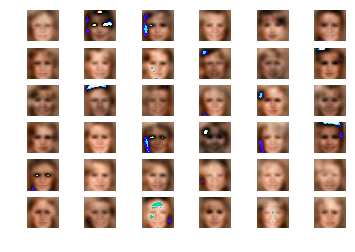

In [21]:
def plot_images(images, subplot_shape):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(*subplot_shape)
    for image, ax in zip(images, axes.flatten()):
        image = image[np.array([2,1,0]),:,:]
        image = np.rollaxis(image / 2 + 0.5, 0, 3)
        ax.imshow(image, vmin=-1.0, vmax=1.0)
        ax.axis('off')
    plt.show()
    
noise = noise_sample(36)
images = G_output.eval({G_input: noise})
plot_images(images, subplot_shape=[6, 6])

Larger number of iterations should generate more realistic looking face images. A sampling of such generated images is shown below.

[1] S. Yang, P. Luo, C. C. Loy, and X. Tang, "From Facial Parts Responses to Face Detection: A Deep Learning Approach", in *IEEE International Conference on Computer Vision (ICCV)*, 2015 